# Install required dependencies

In [ ]:
!pip install openai pillow diffusers transformers accelerate requests bs4
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Import libraries

In [ ]:
import json
import os
import torch
import requests
from dataclasses import dataclass, field
from typing import List, Dict, Optional
from diffusers import StableDiffusionPipeline
from IPython.display import display
from IPython.display import Image as IPImage
import openai
from bs4 import BeautifulSoup
import random
import time
import re
from urllib.parse import urlparse, urljoin

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Input API key


In [ ]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('ChatGPT')

# Define classes

In [ ]:
@dataclass
class ClothingItem:
    name: str
    category: str
    color: str
    owned: bool = False
    price_range: str = "mid-range"  # low, mid-range, high-end
    purchase_links: List[Dict[str, str]] = field(default_factory=list)
    item_id: int = 0  # To identify items in the numbered list

@dataclass
class Outfit:
    items: List[ClothingItem]
    occasion: str
    dress_code: str
    budget: str = "mid-range"  # low, mid-range, high-end
    region: str = "US"  # Default region
    currency: str = "USD"  # Default currency
    generated_image: Optional[str] = None  # Path to saved image

class FashionRecommender:
    def __init__(self, openai_api_key: str):
        self.openai_client = openai.OpenAI(api_key=os.environ['OPENAI_API_KEY'])

        # Region configuration with corresponding currency and budget ranges
        self.regions = {
            "US": {
                "currency": "USD",
                "budget_ranges": {
                    "low": "budget-friendly, affordable options under $50 per item",
                    "mid-range": "mid-priced items generally between $50-$150",
                    "high-end": "premium quality items generally $150+ per piece"
                }
            },
            "UK": {
                "currency": "GBP",
                "budget_ranges": {
                    "low": "budget-friendly, affordable options under £40 per item",
                    "mid-range": "mid-priced items generally between £40-£120",
                    "high-end": "premium quality items generally £120+ per piece"
                }
            },
            "EU": {
                "currency": "EUR",
                "budget_ranges": {
                    "low": "budget-friendly, affordable options under €45 per item",
                    "mid-range": "mid-priced items generally between €45-€135",
                    "high-end": "premium quality items generally €135+ per piece"
                }
            },
            "CA": {
                "currency": "CAD",
                "budget_ranges": {
                    "low": "budget-friendly, affordable options under $65 CAD per item",
                    "mid-range": "mid-priced items generally between $65-$200 CAD",
                    "high-end": "premium quality items generally $200+ CAD per piece"
                }
            },
            "AU": {
                "currency": "AUD",
                "budget_ranges": {
                    "low": "budget-friendly, affordable options under $70 AUD per item",
                    "mid-range": "mid-priced items generally between $70-$200 AUD",
                    "high-end": "premium quality items generally $200+ AUD per piece"
                }
            }
        }

        # Default to US region
        self.current_region = "US"
        self.currency = "USD"

        # Supported retailers with search URL patterns, price ranges, and region availability
        self.retailers = {
            # US Retailers
            "US": {
                "H&M": {
                    "search_url": "https://www2.hm.com/en_us/search-results.html?q={query}",
                    "product_pattern": r"https://www2\.hm\.com/en_us/productpage\.\d+\.html",
                    "price_range": "low"
                },
                "Uniqlo": {
                    "search_url": "https://www.uniqlo.com/us/en/search?q={query}",
                    "product_pattern": r"https://www\.uniqlo\.com/us/en/products/[A-Za-z0-9-]+",
                    "price_range": "low"
                },
                "Target": {
                    "search_url": "https://www.target.com/s?searchTerm={query}",
                    "product_pattern": r"https://www\.target\.com/p/[A-Za-z0-9-]+/-/A-\d+",
                    "price_range": "low"
                },
                "ASOS US": {
                    "search_url": "https://www.asos.com/us/search/?q={query}",
                    "product_pattern": r"https://www\.asos\.com/[^/]+/[^/]+/prd/\d+",
                    "price_range": "mid-range"
                },
                "Gap": {
                    "search_url": "https://www.gap.com/browse/search.do?searchText={query}",
                    "product_pattern": r"https://www\.gap\.com/browse/product\.do\?pid=\d+",
                    "price_range": "mid-range"
                },
                "Madewell": {
                    "search_url": "https://www.madewell.com/search?q={query}",
                    "product_pattern": r"https://www\.madewell\.com/[A-Za-z0-9-]+-[A-Z0-9]+\.html",
                    "price_range": "mid-range"
                },
                "Nordstrom": {
                    "search_url": "https://www.nordstrom.com/sr?keyword={query}",
                    "product_pattern": r"https://www\.nordstrom\.com/s/[^/]+/\d+",
                    "price_range": "high-end"
                },
                "Bloomingdale's": {
                    "search_url": "https://www.bloomingdales.com/shop/search?keyword={query}",
                    "product_pattern": r"https://www\.bloomingdales\.com/shop/product/[^?]+\?ID=\d+",
                    "price_range": "high-end"
                },
                "J.Crew": {
                    "search_url": "https://www.jcrew.com/search?q={query}",
                    "product_pattern": r"https://www\.jcrew\.com/p/[A-Z0-9]+",
                    "price_range": "mid-range"
                }
            },

            # UK Retailers
            "UK": {
                "H&M UK": {
                    "search_url": "https://www2.hm.com/en_gb/search-results.html?q={query}",
                    "product_pattern": r"https://www2\.hm\.com/en_gb/productpage\.\d+\.html",
                    "price_range": "low"
                },
                "ASOS UK": {
                    "search_url": "https://www.asos.com/search/?q={query}",
                    "product_pattern": r"https://www\.asos\.com/[^/]+/[^/]+/prd/\d+",
                    "price_range": "mid-range"
                },
                "Marks & Spencer": {
                    "search_url": "https://www.marksandspencer.com/MSFindItemsByKeyword?searchTerm={query}",
                    "product_pattern": r"https://www\.marksandspencer\.com/[A-Za-z0-9-]+/p/[A-Za-z0-9]+",
                    "price_range": "mid-range"
                },
                "Next": {
                    "search_url": "https://www.next.co.uk/search?w={query}",
                    "product_pattern": r"https://www\.next\.co\.uk/[A-Za-z0-9-]+/[A-Za-z0-9-]+",
                    "price_range": "mid-range"
                },
                "John Lewis": {
                    "search_url": "https://www.johnlewis.com/search?search-term={query}",
                    "product_pattern": r"https://www\.johnlewis\.com/[A-Za-z0-9-]+/p\d+",
                    "price_range": "high-end"
                }
            },

            # EU Retailers
            "EU": {
                "H&M EU": {
                    "search_url": "https://www2.hm.com/en_eur/search-results.html?q={query}",
                    "product_pattern": r"https://www2\.hm\.com/en_eur/productpage\.\d+\.html",
                    "price_range": "low"
                },
                "Zalando": {
                    "search_url": "https://www.zalando.com/en/catalog/?q={query}",
                    "product_pattern": r"https://www\.zalando\.com/[A-Za-z0-9-]+/[A-Za-z0-9-]+",
                    "price_range": "mid-range"
                },
                "Zara EU": {
                    "search_url": "https://www.zara.com/eu/en/search?searchTerm={query}",
                    "product_pattern": r"https://www\.zara\.com/eu/en/[^/]+-p\d+\.html",
                    "price_range": "mid-range"
                },
                "Mango": {
                    "search_url": "https://shop.mango.com/eu/search?kw={query}",
                    "product_pattern": r"https://shop\.mango\.com/[a-z-]+/[^/]+/[A-Za-z0-9-]+_\d+",
                    "price_range": "mid-range"
                }
            },

            # Canada Retailers
            "CA": {
                "H&M CA": {
                    "search_url": "https://www2.hm.com/en_ca/search-results.html?q={query}",
                    "product_pattern": r"https://www2\.hm\.com/en_ca/productpage\.\d+\.html",
                    "price_range": "low"
                },
                "Hudson's Bay": {
                    "search_url": "https://www.thebay.com/search?q={query}",
                    "product_pattern": r"https://www\.thebay\.com/product/[A-Za-z0-9-]+-\d+\.html",
                    "price_range": "mid-range"
                },
                "Simons": {
                    "search_url": "https://www.simons.ca/en/search?q={query}",
                    "product_pattern": r"https://www\.simons\.ca/en/[^/]+/[^/]+/[^/]+--\d+",
                    "price_range": "mid-range"
                }
            },

            # Australia Retailers
            "AU": {
                "The Iconic": {
                    "search_url": "https://www.theiconic.com.au/catalog/?q={query}",
                    "product_pattern": r"https://www\.theiconic\.com\.au/[A-Za-z0-9-]+-\d+\.html",
                    "price_range": "mid-range"
                },
                "Myer": {
                    "search_url": "https://www.myer.com.au/search?query={query}",
                    "product_pattern": r"https://www\.myer\.com\.au/p/[A-Za-z0-9-]+-\d+",
                    "price_range": "mid-range"
                },
                "David Jones": {
                    "search_url": "https://www.davidjones.com/search?q={query}",
                    "product_pattern": r"https://www\.davidjones\.com/product/[A-Za-z0-9-]+-\d+",
                    "price_range": "high-end"
                }
            }
        }

        # User-Agent rotation to avoid being blocked
        self.user_agents = [
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15",
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0",
            "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"
        ]

        # Check if CUDA (GPU) is available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if device == "cpu":
            print("GPU not detected. Using CPU. Note: Image generation will be slower.")
        else:
            print("GPU detected. Using CUDA for faster image generation.")

        print("Loading Stable Diffusion model (this might take a few minutes)...")
        self.sd_pipeline = StableDiffusionPipeline.from_pretrained(
            "stabilityai/stable-diffusion-2-1",
            torch_dtype=torch.float32 if device == "cpu" else torch.float16
        ).to(device)
        print("Model loaded successfully!")

    def get_user_region(self) -> str:
        """Get the user's region preference."""
        print("\nPlease select your region:")
        print("1. United States (US)")
        print("2. United Kingdom (UK)")
        print("3. European Union (EU)")
        print("4. Canada (CA)")
        print("5. Australia (AU)")

        while True:
            choice = input("Enter your choice (1-5): ")
            if choice == "1":
                self.current_region = "US"
                self.currency = self.regions["US"]["currency"]
                return "US"
            elif choice == "2":
                self.current_region = "UK"
                self.currency = self.regions["UK"]["currency"]
                return "UK"
            elif choice == "3":
                self.current_region = "EU"
                self.currency = self.regions["EU"]["currency"]
                return "EU"
            elif choice == "4":
                self.current_region = "CA"
                self.currency = self.regions["CA"]["currency"]
                return "CA"
            elif choice == "5":
                self.current_region = "AU"
                self.currency = self.regions["AU"]["currency"]
                return "AU"
            else:
                print("Please enter a valid choice (1-5).")

    def get_user_budget(self, region: str) -> str:
        """Get the user's budget preference based on region."""
        budget_ranges = self.regions[region]["budget_ranges"]
        currency = self.regions[region]["currency"]

        if region == "US":
            print("\nWhat's your budget for clothing items?")
            print(f"1. Low ({budget_ranges['low']})")
            print(f"2. Mid-range ({budget_ranges['mid-range']})")
            print(f"3. High-end ({budget_ranges['high-end']})")
        elif region == "UK":
            print("\nWhat's your budget for clothing items?")
            print(f"1. Low ({budget_ranges['low']})")
            print(f"2. Mid-range ({budget_ranges['mid-range']})")
            print(f"3. High-end ({budget_ranges['high-end']})")
        elif region == "EU":
            print("\nWhat's your budget for clothing items?")
            print(f"1. Low ({budget_ranges['low']})")
            print(f"2. Mid-range ({budget_ranges['mid-range']})")
            print(f"3. High-end ({budget_ranges['high-end']})")
        elif region == "CA":
            print("\nWhat's your budget for clothing items?")
            print(f"1. Low ({budget_ranges['low']})")
            print(f"2. Mid-range ({budget_ranges['mid-range']})")
            print(f"3. High-end ({budget_ranges['high-end']})")
        elif region == "AU":
            print("\nWhat's your budget for clothing items?")
            print(f"1. Low ({budget_ranges['low']})")
            print(f"2. Mid-range ({budget_ranges['mid-range']})")
            print(f"3. High-end ({budget_ranges['high-end']})")

        while True:
            choice = input("Enter your choice (1-3): ")
            if choice == "1":
                return "low"
            elif choice == "2":
                return "mid-range"
            elif choice == "3":
                return "high-end"
            else:
                print("Please enter a valid choice (1-3).")

    def get_owned_items(self) -> List[Dict[str, str]]:
        """Get items the user already owns."""
        owned_items = []
        print("\nPlease tell us about clothing items you already own and would like to incorporate:")
        print("(Enter 'done' when finished)")

        item_count = 1
        while True:
            print(f"\nItem #{item_count}:")
            item_input = input("Enter item description (e.g., 'navy blue blazer') or 'done' to finish: ")

            if item_input.lower() == 'done':
                break

            # Split into color and item name
            parts = item_input.split()
            if len(parts) >= 2:
                color = " ".join(parts[:-1])
                name = parts[-1]

                # Ask for category
                print("\nSelect category:")
                categories = ["top", "bottom", "outerwear", "footwear", "accessory"]
                for i, category in enumerate(categories, 1):
                    print(f"{i}. {category}")

                while True:
                    cat_choice = input("Enter category number (1-5): ")
                    if cat_choice.isdigit() and 1 <= int(cat_choice) <= 5:
                        category = categories[int(cat_choice)-1]
                        break
                    print("Please enter a valid number (1-5).")

                owned_items.append({
                    "name": name,
                    "color": color,
                    "category": category
                })

                item_count += 1
            else:
                print("Please provide both color and item name (e.g., 'navy blue blazer')")

        return owned_items

    def get_recommendations(self, user_prompt: str, gender: str, budget: str, owned_items: List[Dict[str, str]]) -> Outfit:
        """Generate clothing recommendations based on user prompt, gender, budget and owned items."""
        print("Generating recommendations...")

        # Convert budget to description
        budget_desc = self.regions[self.current_region]["budget_ranges"][budget]

        owned_items_json = json.dumps(owned_items)

        system_prompt = f"""
        You are a fashion expert. Generate clothing recommendations based on the user's gender, requirements, budget, and items they already own.

        Budget level: {budget} ({budget_desc})

        User-owned items: {owned_items_json}

        Generate recommendations in the following JSON format:
        {{
            "occasion": "event type",
            "dress_code": "dress code",
            "gender": "specified gender",
            "items": [
                {{"name": "item name", "category": "category", "color": "color", "price_range": "{budget}"}}
            ]
        }}

        Rules:
        1. Keep the recommendations concise with 3-4 items maximum
        2. Ensure all recommendations are appropriate for the specified gender
        3. Respect the user's budget level by recommending appropriate items
        4. If possible, include combinations with the user's owned items
        5. If an owned item fits well with the outfit, include it in your recommendations and mark it as "owned": true
        6. Each item must have a "price_range" field that matches the user's budget
        """

        # Combine gender and prompt
        full_prompt = f"Gender: {gender}. Budget: {budget}. {user_prompt}"
        if owned_items:
            owned_items_descriptions = []
            for item in owned_items:
                owned_items_descriptions.append(f"{item['color']} {item['name']}")
            full_prompt += f" I already own: {', '.join(owned_items_descriptions)}"

        response = self.openai_client.chat.completions.create(
            model="gpt-4-0125-preview",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": full_prompt}
            ],
            response_format={"type": "json_object"}
        )

        recommendation = json.loads(response.choices[0].message.content)
        outfit = self._create_outfit(recommendation)
        outfit.budget = budget
        return outfit

    def generate_outfit_image(self, outfit: Outfit) -> str:
        """Generate a visual representation of the outfit using Stable Diffusion."""
        user_satisfied = False
        image_path = None

        while not user_satisfied:
            print("Generating outfit visualization...")
            prompt = self._create_image_prompt(outfit)

            # Generate image
            image = self.sd_pipeline(
                prompt,
                negative_prompt="poor quality, low resolution, bad anatomy, disfigured, out of frame, extra limbs",
                num_inference_steps=30,
                guidance_scale=7.5
            ).images[0]

            # Save image
            os.makedirs('generated_images', exist_ok=True)
            image_count = len([f for f in os.listdir('generated_images') if f.startswith('outfit_') and f.endswith('.png')])
            image_path = f'generated_images/outfit_{image_count + 1}.png'
            image.save(image_path)
            outfit.generated_image = image_path

            # Display image in Colab
            display(IPImage(filename=image_path))

            # Print numbered list of recommended items
            print("\n===== List of Recommended Items =====")
            for i, item in enumerate(outfit.items, 1):
                item.item_id = i  # Store item ID for later reference
                ownership = "Already owned" if item.owned else f"New purchase ({item.price_range} price range)"
                print(f"{i}. {item.color} {item.name} ({item.category}) - {ownership}")
            print("====================================\n")

            # Ask if user is satisfied
            satisfaction = input("\nAre you satisfied with this outfit visualization? (yes/no): ").lower()
            user_satisfied = satisfaction == 'yes'

            if not user_satisfied:
                print("Let's generate a new visualization...")

        print(f"Great! Image saved at: {image_path}")
        return image_path

    def check_item_ownership(self, item: ClothingItem) -> ClothingItem:
        """Check if the user already owns this item."""
        if not item.owned:  # Only ask if not already marked as owned
            owned = input(f"Do you already own the {item.color} {item.name}? (yes/no): ").lower() == 'yes'
            item.owned = owned
        return item

    def find_purchase_links(self, item: ClothingItem, user_budget: str, region: str, max_retailers=3) -> List[Dict[str, str]]:
        """Find specific product purchase links based on user budget and region."""
        if item.owned:
            return []

        print(f"\nSearching for {item.color} {item.name} in {user_budget} price range for {region} region...")
        results = []
        search_query = f"{item.color} {item.name}"

        # Get retailers for the selected region
        region_retailers = self.retailers.get(region, {})
        if not region_retailers:
            print(f"No retailers configured for region {region}. Falling back to US retailers.")
            region_retailers = self.retailers.get("US", {})

        # Filter retailers by budget
        budget_retailers = {name: info for name, info in region_retailers.items()
                          if info["price_range"] == user_budget}

        # If no retailers match budget exactly, include adjacent budget categories
        if not budget_retailers:
            if user_budget == "low":
                budget_retailers = {name: info for name, info in region_retailers.items()
                                  if info["price_range"] in ["low", "mid-range"]}
            elif user_budget == "high-end":
                budget_retailers = {name: info for name, info in region_retailers.items()
                                  if info["price_range"] in ["high-end", "mid-range"]}
            else:  # mid-range
                budget_retailers = region_retailers

        # Select random retailers from filtered list
        if budget_retailers:
            selected_retailers = random.sample(list(budget_retailers.items()),
                                             min(max_retailers, len(budget_retailers)))
        else:
            selected_retailers = []
            print(f"No retailers found for {region} region with {user_budget} budget.")

        for retailer_name, retailer_info in selected_retailers:
            try:
                print(f"Searching on {retailer_name}...")
                search_url = retailer_info["search_url"].format(query=search_query.replace(" ", "+"))

                # Rotate user agents
                headers = {"User-Agent": random.choice(self.user_agents)}

                # Get search results page
                response = requests.get(search_url, headers=headers, timeout=15)
                if response.status_code != 200:
                    print(f"Failed to access {retailer_name}, status code: {response.status_code}")
                    continue

                # Parse HTML
                soup = BeautifulSoup(response.text, 'html.parser')

                # Extract all links from the page
                links = []
                for a in soup.find_all('a', href=True):
                    href = a.get('href')
                    # Handle relative URLs
                    if href and not href.startswith(('http://', 'https://')):
                        href = urljoin(search_url, href)
                    if href:
                        links.append(href)

                # Find product links using regex pattern
                product_pattern = retailer_info.get("product_pattern")
                product_links = []

                for link in links:
                    if re.search(product_pattern, link):
                        product_links.append(link)

                # Get unique links
                product_links = list(set(product_links))[:2]  # Limit to 2 per retailer

                # Verify and add product links
                for product_url in product_links:
                    try:
                        # Verify the link is accessible with a HEAD request
                        head_response = requests.head(
                            product_url,
                            headers=headers,
                            timeout=5,
                            allow_redirects=True
                        )

                        if head_response.status_code < 400:  # Accept any successful status code
                            results.append({
                                "store": retailer_name,
                                "url": product_url
                            })
                            print(f"Found product at {retailer_name}: {product_url}")

                            # Limit to one verified product per retailer
                            break
                    except Exception as e:
                        print(f"Link verification failed for {product_url}: {str(e)}")

            except Exception as e:
                print(f"Error searching {retailer_name}: {str(e)}")

            # Add delay to avoid being blocked
            time.sleep(random.uniform(1.5, 3.0))

        # If web scraping didn't yield enough results, fall back to retailer search pages
        if len(results) < 2:
            print("Adding search page links for additional retailers...")
            fallback_results = self._get_search_page_links(item, user_budget, region)

            # Add the fallback links
            for link in fallback_results:
                if len(results) >= 3:
                    break
                if not any(r["store"] == link["store"] for r in results):  # Avoid duplicates
                    results.append(link)

        return results

    def _get_search_page_links(self, item: ClothingItem, user_budget: str, region: str) -> List[Dict[str, str]]:
        """Provide direct search page links for major retailers based on budget and region."""
        search_query = f"{item.color} {item.name}".replace(" ", "+")
        fallback_links = []

        # Get retailers for the selected region
        region_retailers = self.retailers.get(region, {})
        if not region_retailers:
            region_retailers = self.retailers.get("US", {})  # Default to US

        # Filter retailers by budget
        budget_retailers = {name: info for name, info in region_retailers.items()
                          if info["price_range"] == user_budget}

        # Add links to search pages
        for retailer_name, retailer_info in budget_retailers.items():
            search_url = retailer_info["search_url"].format(query=search_query)
            fallback_links.append({
                "store": f"{retailer_name} (Search Results)",
                "url": search_url
            })

        return fallback_links

    def _create_outfit(self, recommendation: Dict) -> Outfit:
        """Create Outfit object from recommendation dictionary."""
        items = []
        for item in recommendation['items']:
            # Create clothing item
            clothing_item = ClothingItem(
                name=item['name'],
                category=item['category'],
                color=item['color'],
                price_range=item.get('price_range', 'mid-range')
            )

            # Check if this is an owned item
            if 'owned' in item and item['owned']:
                clothing_item.owned = True

            # Add to items list
            items.append(clothing_item)

        # Create and return outfit
        return Outfit(
            items=items,
            occasion=recommendation['occasion'],
            dress_code=recommendation['dress_code']
        )

    def _create_image_prompt(self, outfit: Outfit) -> str:
        """Create detailed prompt for Stable Diffusion based on outfit."""
        # Get all items with clear indication of owned vs new
        items_description = []
        for item in outfit.items:
            item_desc = f"{item.color} {item.name}"
            if item.owned:
                items_description.append(f"their own {item_desc}")
            else:
                items_description.append(f"a {item_desc}")

        items_text = ", ".join(items_description)

        prompt = f"""
        Professional fashion photography of a person wearing {items_text}.
        Occasion: {outfit.occasion}.
        Style: {outfit.dress_code}.
        Budget level: {outfit.budget}.
        Full body shot, fashion magazine quality, professional lighting, photorealistic, high detail, 4k,
        neutral background, fashion lookbook style
        """
        return prompt

GPU detected. Using CUDA for faster image generation.
Loading Stable Diffusion model (this might take a few minutes)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Model loaded successfully!
Welcome to Style Genius! Smart styling, effortless you.
Let's create a perfect outfit for you!
--------------------------------------

Please select your region:
1. United States (US)
2. United Kingdom (UK)
3. European Union (EU)
4. Canada (CA)
5. Australia (AU)
Enter your choice (1-5): 2

Please specify your gender (male/female): MALE

What's your budget for clothing items?
1. Low (budget-friendly, affordable options under £40 per item)
2. Mid-range (mid-priced items generally between £40-£120)
3. High-end (premium quality items generally £120+ per piece)
Enter your choice (1-3): 1

Let's identify items you already own that could be incorporated into recommendations.

Please tell us about clothing items you already own and would like to incorporate:
(Enter 'done' when finished)

Item #1:
Enter item description (e.g., 'navy blue blazer') or 'done' to finish: DONE

Please describe your fashion needs:
Example: I'm going to attend an outdoor wedding, and the the

  0%|          | 0/30 [00:00<?, ?it/s]

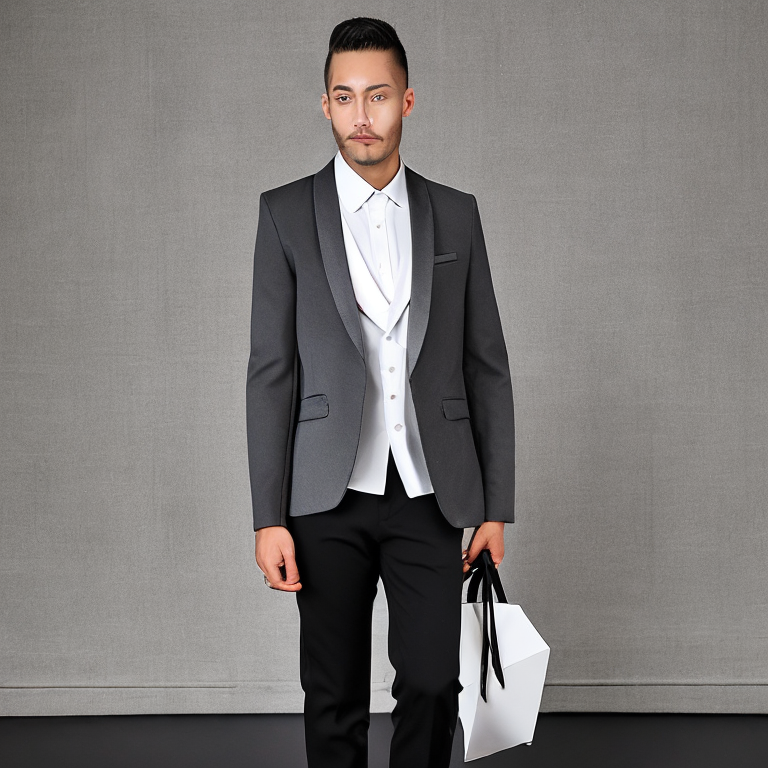


===== List of Recommended Items =====
1. grey Grey Blazer (outerwear) - New purchase (low price range)
2. white White Dress Shirt (shirt) - New purchase (low price range)
3. black Black Dress Pants (pants) - New purchase (low price range)
4. black Black Dress Shoes (shoes) - New purchase (low price range)


Are you satisfied with this outfit visualization? (yes/no): Yes
Great! Image saved at: generated_images/outfit_1.png

Let's find shopping options for items you need to purchase:

Searching for grey Grey Blazer in low price range for UK region...
Searching on H&M UK...
Found product at H&M UK: https://www2.hm.com/en_gb/productpage.1272456002.html
Adding search page links for additional retailers...

Purchase options for grey Grey Blazer (Item #1):
- H&M UK: https://www2.hm.com/en_gb/productpage.1272456002.html
- H&M UK (Search Results): https://www2.hm.com/en_gb/search-results.html?q=grey+Grey+Blazer

Searching for white White Dress Shirt in low price range for UK region...
Searchin

In [ ]:
def main():
    # Check CUDA availability
    if not torch.cuda.is_available():
        print("WARNING: No GPU detected. The image generation will be significantly slower on CPU.")
        proceed = input("Do you want to continue? (yes/no): ").lower()
        if proceed != 'yes':
            print("Exiting program.")
            return

    # Get OpenAI API key
    openai_api_key = os.environ['OPENAI_API_KEY']

    # Initialize the recommender
    recommender = FashionRecommender(openai_api_key=openai_api_key)

    print("Welcome to Style Genius! Smart styling, effortless you.")
    print("Let's create a perfect outfit for you!")
    print("--------------------------------------")

    # Get region input
    region = recommender.get_user_region()

    # Get gender input
    while True:
        gender = input("\nPlease specify your gender (male/female): ").lower()
        if gender in ['male', 'female']:
            break
        print("Please enter either 'male' or 'female'")

    # Get budget preference based on region
    budget = recommender.get_user_budget(region)

    # Get owned items
    print("\nLet's identify items you already own that could be incorporated into recommendations.")
    owned_items = recommender.get_owned_items()

    # Get fashion request
    print("\nPlease describe your fashion needs:")
    print("Example: I'm going to attend an outdoor wedding, and the theme is casual. I need something with dark blue colors.")
    user_prompt = input("> ")

    # Get recommendations
    outfit = recommender.get_recommendations(user_prompt, gender, budget, owned_items)
    outfit.region = region
    outfit.currency = recommender.currency

    # Print recommendations
    print("\nRecommended Outfit:")
    print(f"Occasion: {outfit.occasion}")
    print(f"Dress Code: {outfit.dress_code}")
    print(f"Budget Level: {outfit.budget} ({recommender.regions[region]['budget_ranges'][outfit.budget]})")
    print(f"Region: {region}")
    print("\nItems:")
    for item in outfit.items:
        ownership = "Already owned" if item.owned else f"New purchase ({item.price_range} price range)"
        print(f"- {item.color} {item.name} ({item.category}) - {ownership}")

    # Generate visualization
    print("\nGenerating outfit visualization...")
    image_path = recommender.generate_outfit_image(outfit)

    # Check ownership and get purchase links for items not already marked as owned
    print("\nLet's find shopping options for items you need to purchase:")
    items_to_purchase = [item for item in outfit.items if not item.owned]

    if not items_to_purchase:
        print("Great news! You already own all the items needed for this outfit.")
    else:
        for item in items_to_purchase:
            item.purchase_links = recommender.find_purchase_links(item, budget, region)
            print(f"\nPurchase options for {item.color} {item.name} (Item #{item.item_id}):")
            if item.purchase_links:
                for link in item.purchase_links:
                    print(f"- {link['store']}: {link['url']}")
            else:
                print("No specific product links found. Try searching online retailers directly.")

if __name__ == "__main__":
    main()